# Basal melt rates

# Kinetic energy, ocean heat content and average salinity
## Preprocessing
Load data, get cartesian coordinates, calculate time dependent volumes of cells and interpolate velocities onto rho grid.

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

import os
import sys

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.environ.get('projdir'),'src')
sys.path.append(src_dir)

# import my methods, make sure they get reloded by each call
from features.cartesian_grid_3d import cartesian_grid_3d
from features.rotate_vector_roms import rotate_vector_roms
from features.calc_z import calc_z
from features.log_progress import log_progress
import gsw

%load_ext memory_profiler

In [3]:
import xarray as xr
import numpy as np
src_dir = os.path.join(os.environ.get('projdir'),'src')
sys.path.append(src_dir)
from features.rotate_vector_roms import rotate_vector_roms
from features.calc_z import calc_z
import gsw

def make_cartesian_grid_3D(grd,ds):

    lon_u = grd.lon_u.values
    lat_u = grd.lat_u.values
    lon_v = grd.lon_v.values
    lat_v = grd.lat_v.values
    h = grd.h.values
    zice = grd.zice.values
    theta_s = ds.theta_s.values
    theta_b = ds.theta_b.values
    hc = ds.hc.values
    N = ds.s_rho.size

    zeta = ds.zeta.values

    dx,dy,dz,z = cartesian_grid_3d(lon_u, lat_u, lon_v, lat_v, h, zice, theta_s, theta_b, hc, N, zeta)

    ds['dx'] = xr.DataArray(dx,dims=['s_rho','eta_rho','xi_rho'])
    ds['dx'] = ds.dx.where(ds.mask_rho == 1)

    ds['dy'] = xr.DataArray(dy,dims=['s_rho','eta_rho','xi_rho'])
    ds['dy'] = ds.dy.where(ds.mask_rho == 1)

    ds['dz'] = xr.DataArray(dz,dims=['s_rho','eta_rho','xi_rho'])
    ds['dz'] = ds.dz.where(ds.mask_rho == 1)

    ds['z'] = xr.DataArray(z,dims=['s_rho','eta_rho','xi_rho'])
    ds['z'] = ds.z.where(ds.mask_rho == 1)

    dV = ds.dx * ds.dy * ds.dz
    ds['dV'] = dV

    return ds

def make_uv_lonlat(grd,ds):

    angle = grd.angle.values

    u_lonlat = np.empty((ds.s_rho.size,ds.eta_rho.size,ds.xi_rho.size))
    v_lonlat = np.empty((ds.s_rho.size,ds.eta_rho.size,ds.xi_rho.size))


    for level in np.arange(ds.s_rho.size):
        u=ds.u[level].values
        v=ds.v[level].values

        u_lonlat[level],v_lonlat[level] = rotate_vector_roms(u,v,angle)

    ds['u_lonlat'] = xr.DataArray(u_lonlat,dims=['s_rho','eta_rho','xi_rho'])
    ds['u_lonlat'] = ds.u_lonlat.where(ds.mask_rho == 1)
    ds.u_lonlat.attrs = ds.u.attrs

    ds['v_lonlat'] = xr.DataArray(v_lonlat,dims=['s_rho','eta_rho','xi_rho'])
    ds['v_lonlat'] = ds.v_lonlat.where(ds.mask_rho == 1)
    ds.v_lonlat.attrs = ds.v.attrs

    return ds

def make_depth(grd,ds):

    h = grd.h.values
    zice = grd.zice.values
    theta_s = ds.theta_s.values
    theta_b = ds.theta_b.values
    hc = ds.hc.values
    N = ds.s_rho.size
    zeta = ds.zeta.values
    Vstretching = ds.Vstretching.values

    depths,s,C = calc_z(h,zice,theta_s,theta_b,hc,N,zeta,Vstretching)

    ds = ds.assign_coords(depth = xr.DataArray(depths,dims=['s_rho','eta_rho','xi_rho']))

    return ds

def make_density(grd,ds):
    
    p = gsw.conversions.p_from_z(ds.depth,grd.lat_rho)
    SA = gsw.conversions.SA_from_SP(ds.salt,p,grd.lon_rho,grd.lat_rho)
    CT = gsw.conversions.CT_from_pt(SA,ds.temp)
    
    ds['rho']=(('s_rho','eta_rho','xi_rho'),gsw.density.rho(SA,CT,p))
    
    return ds

In [4]:
def timeseries_3d(avg,grd):
    ohc = {}
    ke = {}
    avg_salt = {}

    for dic in [ohc,ke,avg_salt]:
        for quant in ['cavity','shelf','deep_oo','shallow_oo']:
            dic[quant] = []

    for time in log_progress(avg.ocean_time,name='times'):

        ds = avg.sel(ocean_time=time)
        #print('processing time: ',ds.ocean_time.values)

        #print('making 3d volumes, uv_lonlat, depths')
        ds = make_cartesian_grid_3D(grd,ds)
        ds = make_uv_lonlat(grd,ds)
        ds = make_depth(grd,ds)
        ds = make_density(grd,ds)

        Cp = 3974        # Specific heat of polar seawater (J/K/kg)
        C2K = 273.15     # Celsius to Kelvin conversion

        #rho = ds.rho+ds.rho0
        #rho = ds.rho0

        #print('calculating ocean heat content of each cell')
        ds['ohc'] = (('s_rho','eta_rho','xi_rho'),(ds.temp+C2K)*ds.rho*Cp*ds.dV)

        #print('calculating kinetic energy of each cell')
        ds['ke'] = (('s_rho','eta_rho','xi_rho'),0.5*ds.rho*(ds.u_lonlat**2 + ds.v_lonlat**2)*ds.dV)

        #print('calculating ohc, ke and avg_salt in the cavities, shelf ocean, shallow open ocean and deep open ocean')
        mask_cavity = (grd.zice < 0.0) & (grd.mask_rho==1)
        weights_cavity = (ds.dV*ds.rho).where(mask_cavity)/(ds.dV*ds.rho).where(mask_cavity).sum()

        ohc['cavity'].append((ds.ohc.where(mask_cavity)).sum().values) 
        ke['cavity'].append((ds.ke.where(mask_cavity)).sum().values)
        avg_salt['cavity'].append((ds.salt.where(mask_cavity)*weights_cavity).sum().values)

        mask_shelf= (grd.lat_rho<-60) & ((grd.h < 1000) | (ds.zice < 0.0))
        weights_shelf = (ds.dV*ds.rho).where(mask_shelf)/((ds.dV*ds.rho).where(mask_shelf)).sum()

        ohc['shelf'].append((ds.ohc.where(mask_shelf)).sum().values)
        ke['shelf'].append((ds.ke.where(mask_shelf)).sum().values)
        avg_salt['shelf'].append((ds.salt.where(mask_shelf)*weights_shelf).sum().values)

        mask_oos =  (ds.depth > -500) & (~mask_shelf)
        weights_oos = (ds.dV*ds.rho).where(mask_oos)/((ds.dV*ds.rho).where(mask_oos)).sum()

        mask_ood =  (ds.depth < -500) & (~mask_shelf)
        weights_ood = (ds.dV*ds.rho).where(mask_ood)/((ds.dV*ds.rho).where(mask_ood)).sum()

        ohc['shallow_oo'].append((ds.ohc.where(mask_oos)).sum().values)
        ke['shallow_oo'].append((ds.ke.where(mask_oos)).sum().values)
        avg_salt['shallow_oo'].append((ds.salt.where(mask_oos)*weights_oos).sum().values)

        ohc['deep_oo'].append((ds.ohc.where(mask_ood)).sum().values)
        ke['deep_oo'].append((ds.ke.where(mask_ood)).sum().values)
        avg_salt['deep_oo'].append((ds.salt.where(mask_ood)*weights_ood).sum().values)
        
    for quant,data in zip(['total_OHC','total_KE','avg_SALT'],[ohc,ke,avg_salt]):
        for area in ['cavity','shelf','shallow_oo','deep_oo']:
            avg[quant+'_'+area]=(('ocean_time'),(data[area]-data[area][0])/data[area][0]*100)
            avg[quant+'_'+area].plot(label=area)
    
    return avg

Load files:  /home/ubuntu/bigStick/tidal_melting/data/analysis/raw/hre10/ocean_avg_00??.nc


VBox(children=(HTML(value=''), IntProgress(value=0, max=404)))

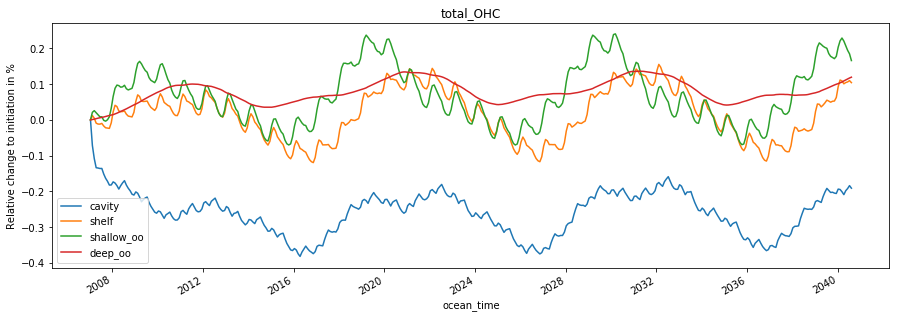

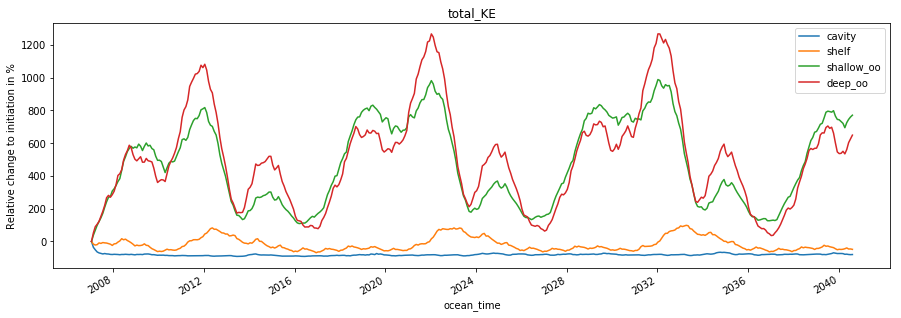

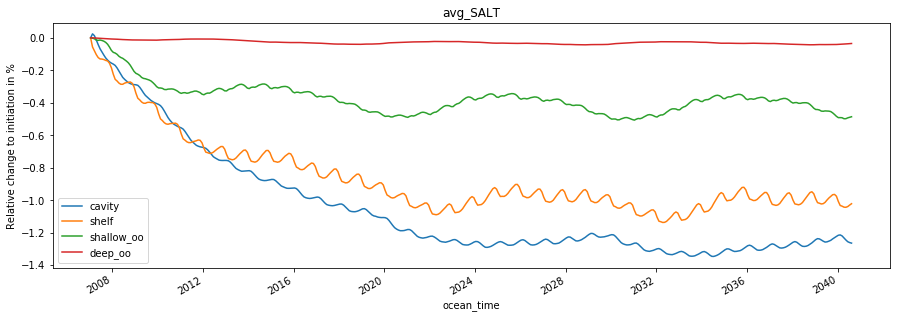

In [21]:
file_path = os.path.join(os.environ.get('rawdir'),'hre10','ocean_avg_00??.nc')
grd_path = os.path.join(os.environ.get('rawdir'),'gdata','hr_exp','waom10_grd.nc')


print('Load files: ',file_path)
avg = xr.open_mfdataset(file_path,chunks={'xi_rho':200,'eta_rho':200})
grd = xr.open_dataset(grd_path)

avg = timeseries_3d(avg,grd)

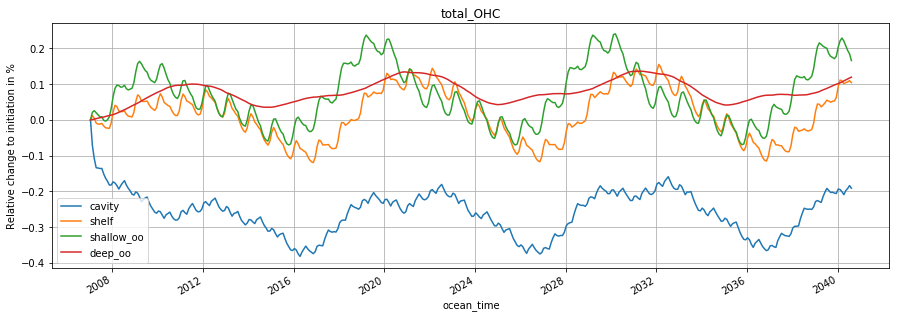

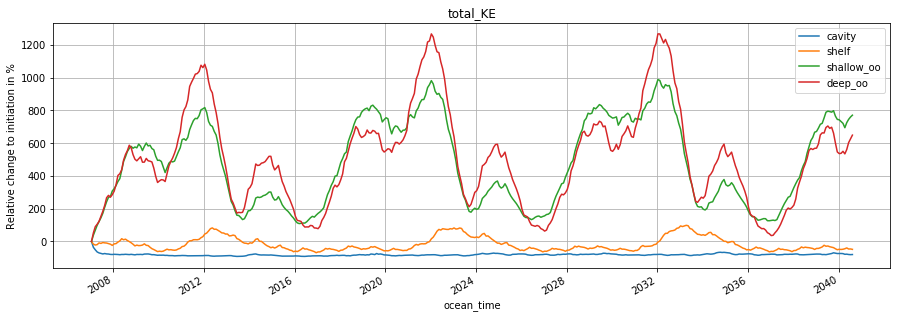

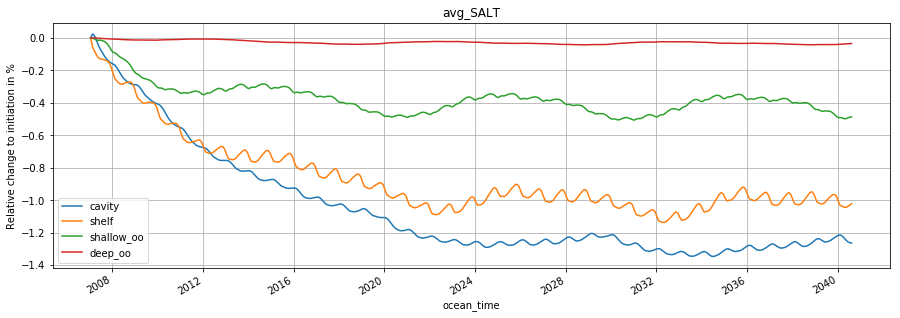

In [22]:
plt.close()
for quant,data in zip(['total_OHC','total_KE','avg_SALT'],[ohc,ke,avg_salt]):
    plt.figure(figsize=(15,5))
    for area in ['cavity','shelf','shallow_oo','deep_oo']:
        avg[quant+'_'+area].plot(label=area)
    plt.legend()
    plt.title(quant)
    plt.grid('True')
    plt.ylabel('Relative change to initiation in %')   
    plt.show()

In [7]:
lon_l={}
lon_u={}

for sector,ll,lu in zip(['weddell','indian','pacific','ross','ba'],[-60,20,90,160,-130],[20,90,160,-130,-60]):
    lon_l[sector]=ll
    lon_u[sector]=lu

In [5]:
def timeseries_3d_sectors(avg,grd):
    
    s2a = 365*24*3600
    data = {}

    for sector in ['weddell','indian','pacific','ross','ba']:
        data[sector]={}
        data[sector]['melt'] = []
        for qunat in ['salt','temp','velo']:
            data[sector][qunat] = {}
            for area in ['cavity','shelf','oos','ood']:
                data[sector][qunat][area] = []
                
            

    for time in log_progress(avg.ocean_time,name='times'):
        
        #print('prepare time step')
        ds = avg.sel(ocean_time=time)
        ds = make_cartesian_grid_3D(grd,ds)
        ds = make_depth(grd,ds)
        ds = make_density(grd,ds)
        ds = make_uv_lonlat(grd,ds)
        
        #print('define masks')
        ds['mask_cavity'] = (grd.zice < 0.0) & (grd.mask_rho==1)
        ds['mask_shelf'] = (grd.lat_rho<-60) & ((grd.h < 1000) | (ds.zice < 0.0))
        ds['mask_oos'] =  (ds.depth > -500) & (~ds.mask_shelf)
        ds['mask_ood'] =  (ds.depth < -500) & (~ds.mask_shelf)
        
        
        for sector in ['weddell','indian','pacific','ross','ba']:
            #print('processing sector '+sector)
            
            if lon_l[sector]<lon_u[sector]:
                mask_sector = (grd.lon_rho>lon_l[sector]) & (grd.lon_rho<=lon_u[sector])
            else:
                mask_sector = (grd.lon_rho>lon_l[sector]) | (grd.lon_rho<=lon_u[sector])
                
            mask = ds['mask_cavity'] & mask_sector
                
            dA = (1.0/(grd.pm.where(mask) *grd.pn.where(mask)))
            weights = (dA/dA.sum())
            
            data[sector]['melt'].append((ds.m*weights).sum(['eta_rho','xi_rho']).values*s2a)
            
            for area in ['cavity','shelf','oos','ood']:
                #print('processing area '+area)
            
                mask = (ds['mask_'+area]) & mask_sector
                weights = (ds.dV.where(mask)*ds.rho.where(mask))/(ds.dV.where(mask)*ds.rho.where(mask)).sum()
                
                data[sector]['salt'][area].append((ds.where(mask).salt*weights).sum().values)
                data[sector]['temp'][area].append((ds.where(mask).temp*weights).sum().values)
                data[sector]['velo'][area].append((xr.ufuncs.sqrt(ds.where(mask).u_lonlat**2 +\
                                                        ds.where(mask).v_lonlat**2)*weights).sum().values)
    
    plt.close()
    plt.figure(figsize=(15,5))
    for sector in ['weddell','indian','pacific','ross','ba']:
        avg['melt_'+sector]=(('ocean_time'),data[sector]['melt'])
        avg['melt_'+sector].plot(label=sector)
    plt.legend()
    plt.title('avg melt in m/yr')
    plt.grid('True')
    plt.ylabel('')   
    plt.show()

    
    for quant,unit in zip(['salt','temp','velo'],['PSU','degC','m/s']):
        for area in ['cavity','shelf','oos','ood']:
            plt.figure(figsize=(15,5))
            for sector in ['weddell','indian','pacific','ross','ba']:
                avg[quant+'_'+sector+'_'+area]=(('ocean_time'),data[sector][qunat][area])
                avg[quant+'_'+sector+'_'+area].plot(label=sector)
            plt.legend()
            plt.title(area+' avg '+quant+' in '+unit)
            plt.grid('True')
            plt.ylabel('')   
            plt.show()
    
    return avg

In [8]:
file_path = os.path.join(os.environ.get('rawdir'),'hre10_stable','ocean_avg_00??.nc')
grd_path = os.path.join(os.environ.get('rawdir'),'gdata','hr_exp','waom10_grd.nc')


print('Load files: ',file_path)
avg = xr.open_mfdataset(file_path,chunks={'xi_rho':200,'eta_rho':200})
grd = xr.open_dataset(grd_path)


avg_test = timeseries_3d_sectors(avg,grd)

Load files:  /home/ubuntu/bigStick/tidal_melting/data/analysis/raw/hre10_stable/ocean_avg_00??.nc


VBox(children=(HTML(value=''), IntProgress(value=0, max=6)))

KeyboardInterrupt: 

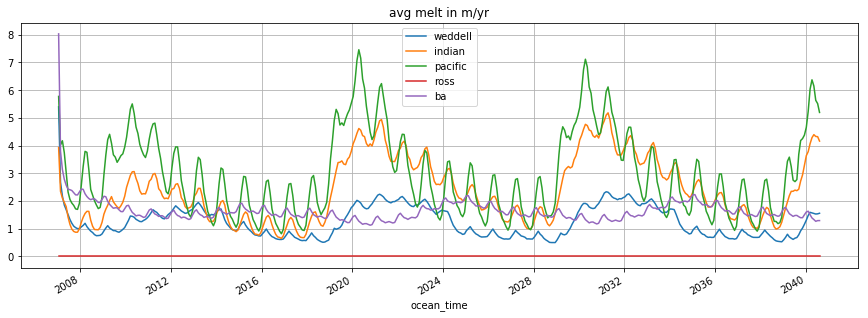

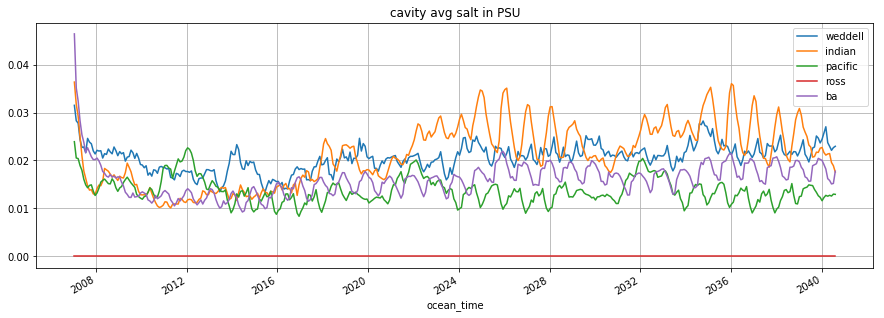

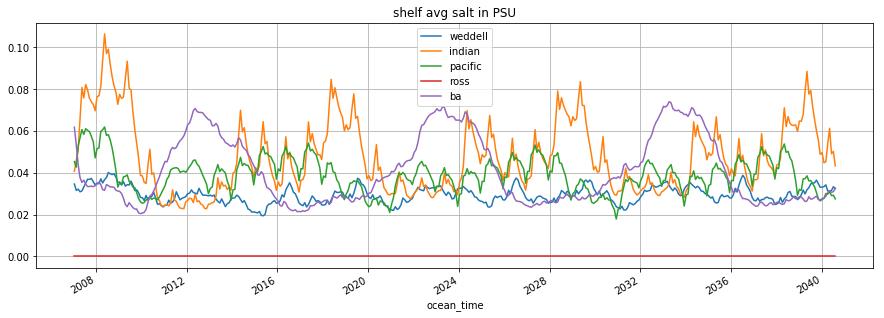

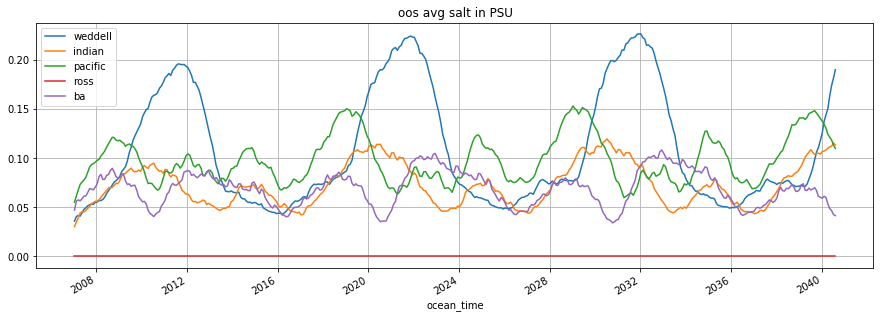

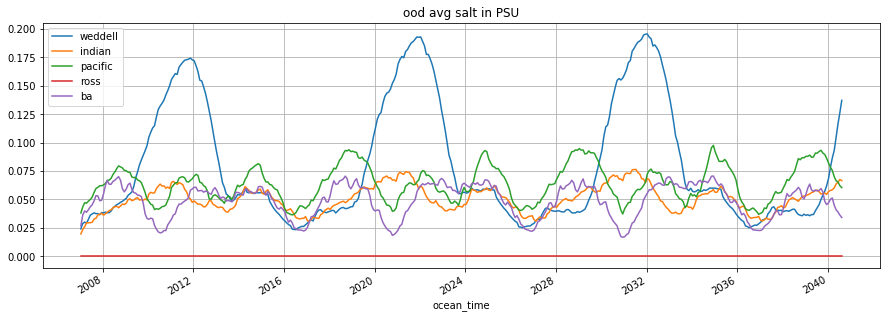

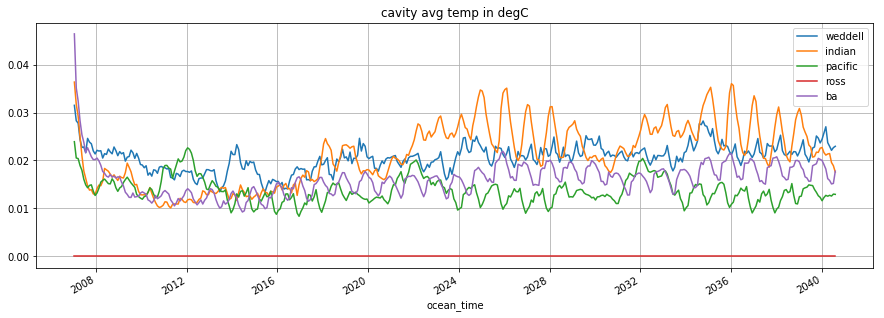

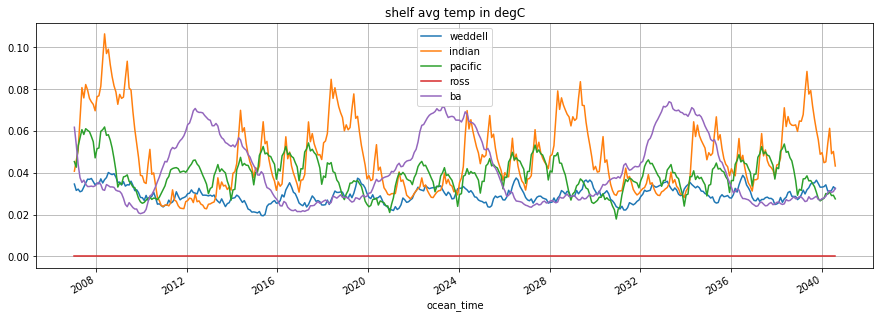

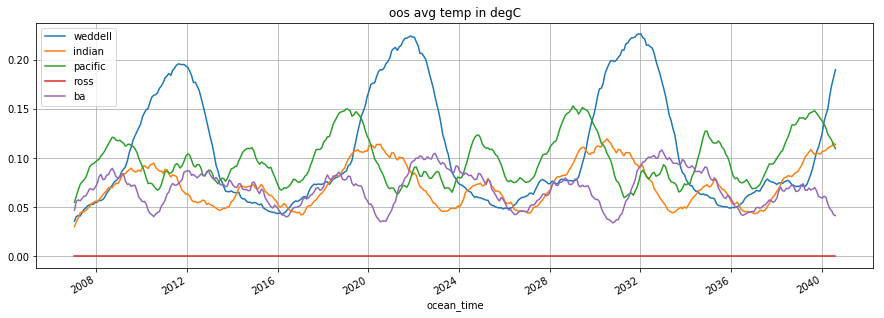

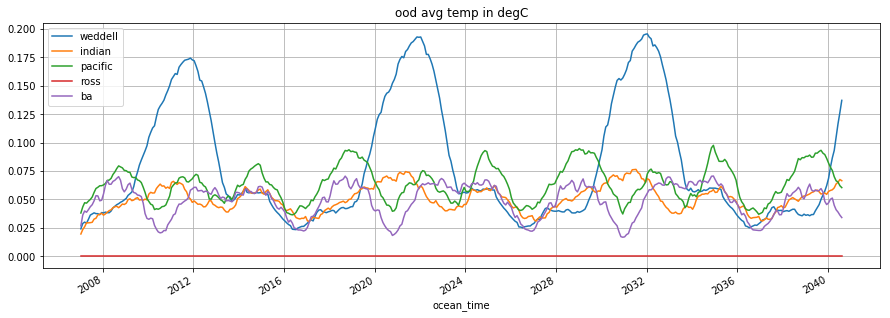

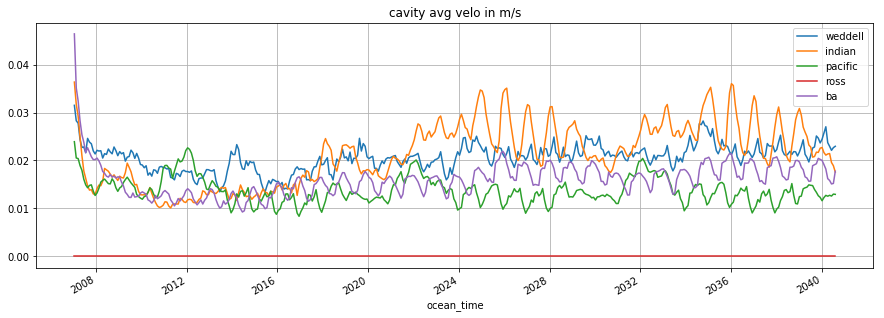

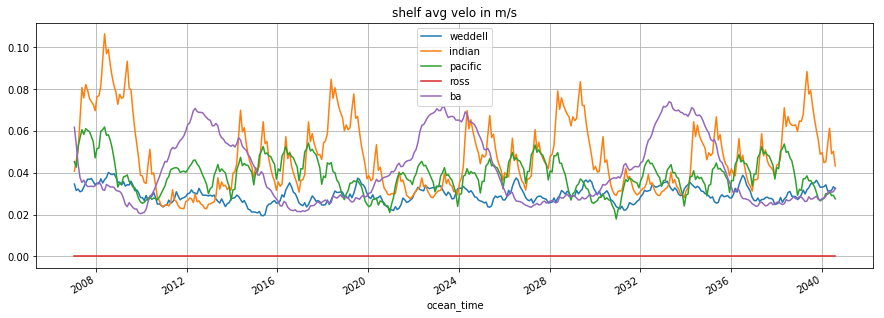

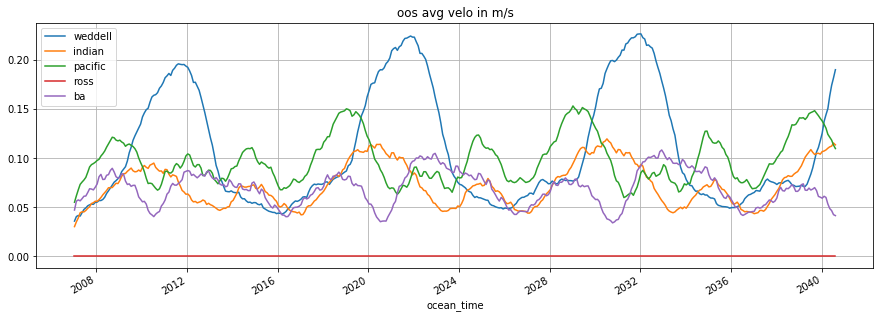

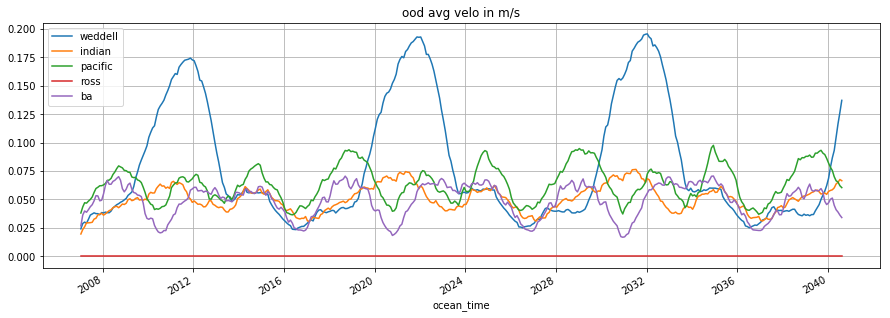

In [73]:
plt.close()
plt.figure(figsize=(15,5))
for sector in ['weddell','indian','pacific','ross','ba']:
    avg['melt_'+sector].plot(label=sector)
plt.legend()
plt.title('avg melt in m/yr')
plt.grid('True')
plt.ylabel('')   
plt.show()
    
for quant,unit in zip(['salt','temp','velo'],['PSU','degC','m/s']):
    for area in ['cavity','shelf','oos','ood']:
        plt.figure(figsize=(15,5))
        for sector in ['weddell','indian','pacific','ross','ba']:
            avg[quant+'_'+sector+'_'+area].plot(label=sector)
        plt.legend()
        plt.title(area+' avg '+quant+' in '+unit)
        plt.grid('True')
        plt.ylabel('')   
        plt.show()

Load files:  /home/ubuntu/bigStick/tidal_melting/data/analysis/raw/hre10_nudg/ocean_avg_00??.nc


VBox(children=(HTML(value=''), IntProgress(value=0, max=201)))

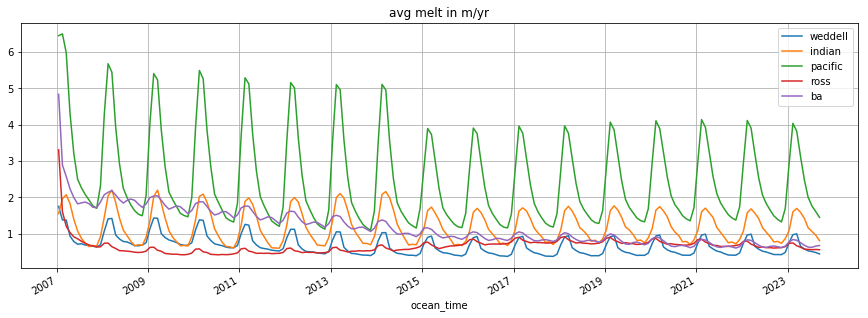

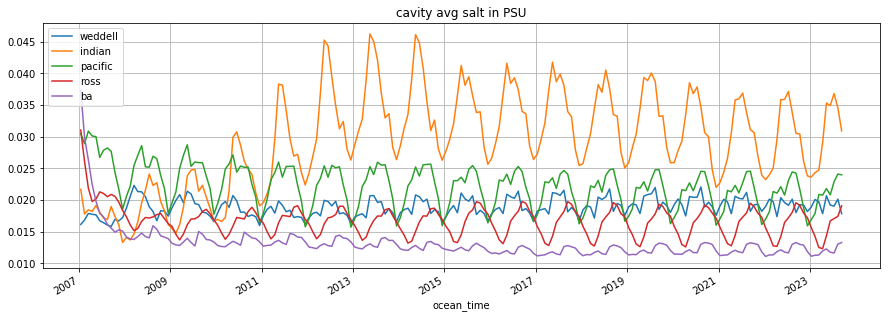

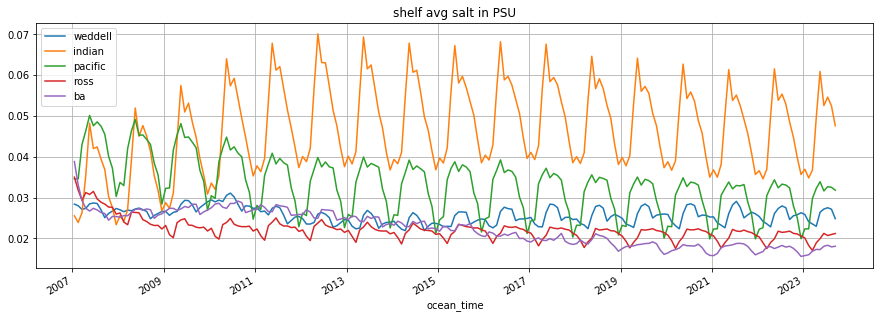

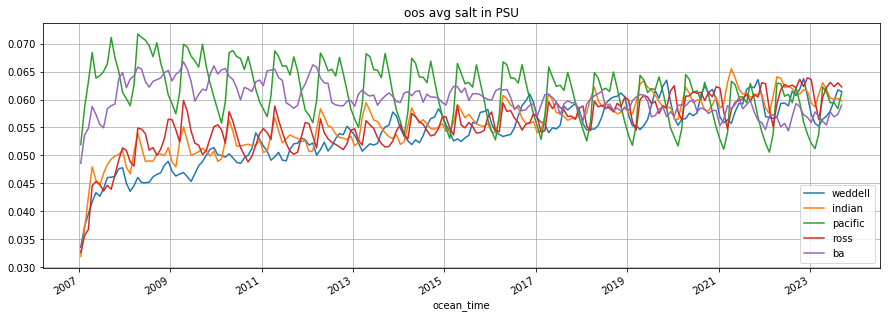

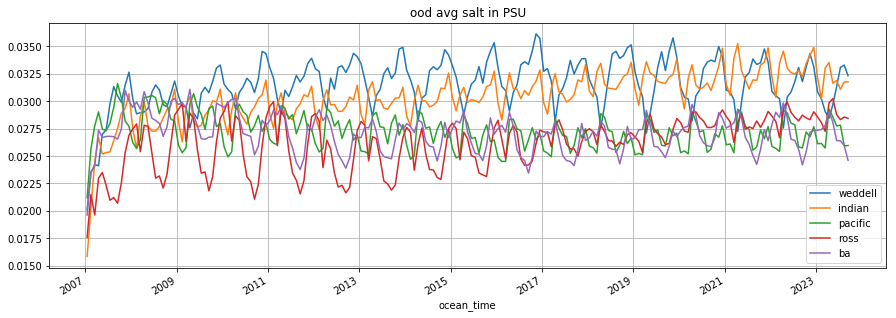

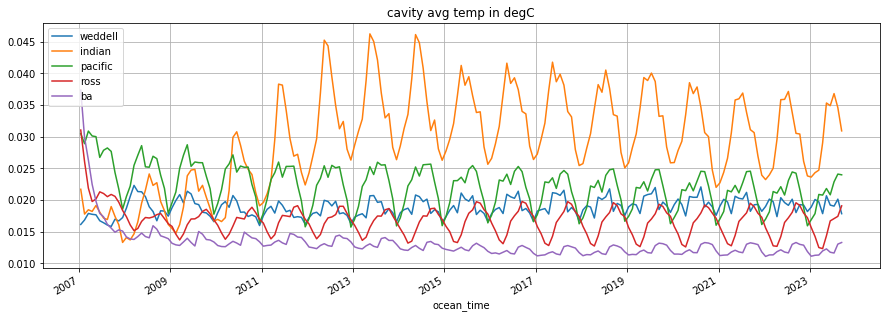

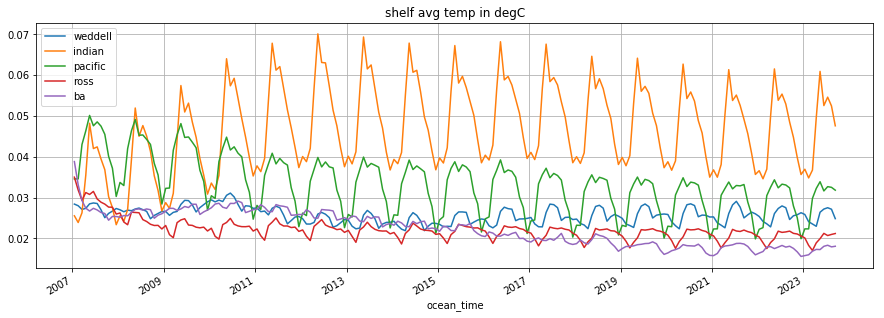

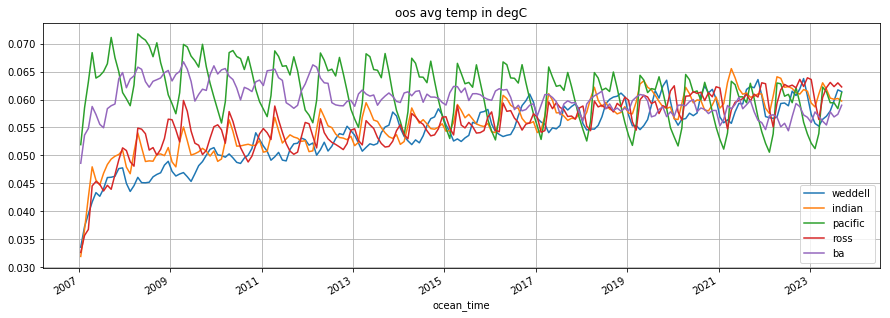

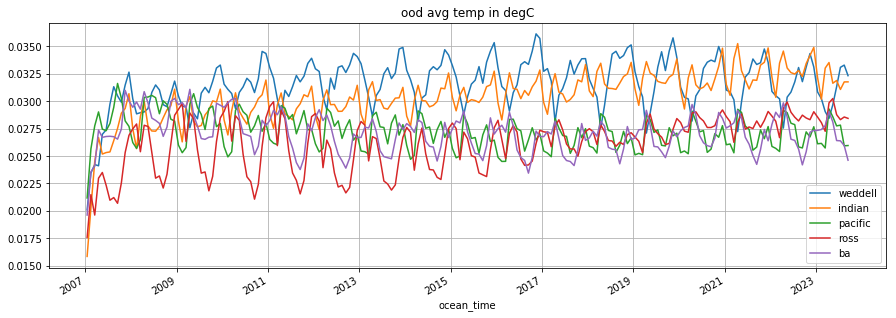

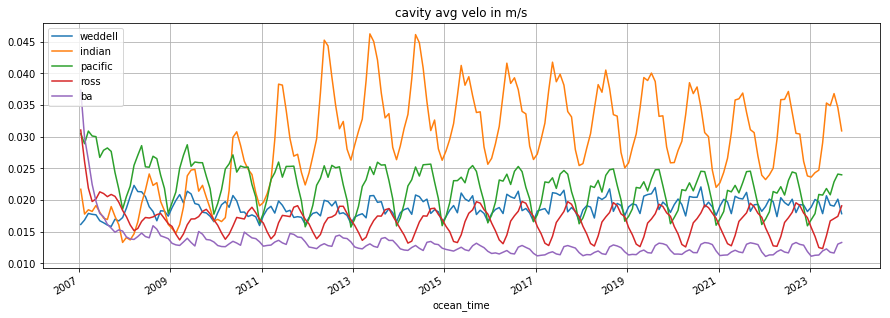

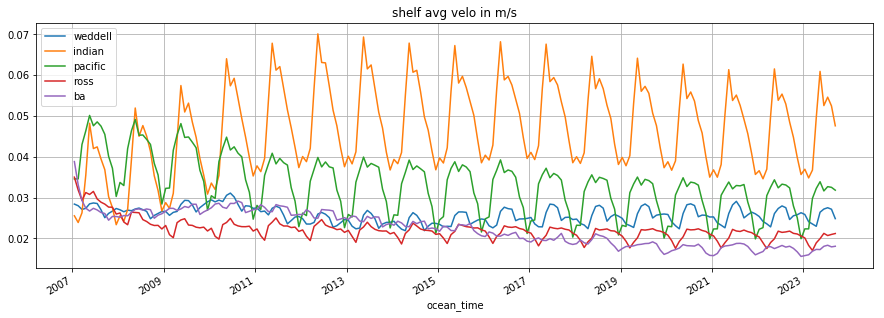

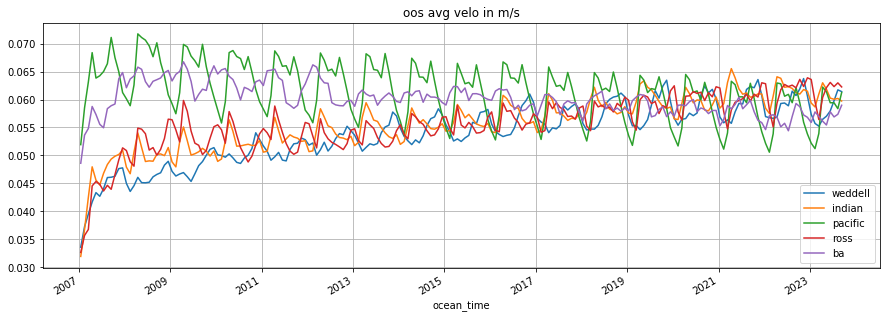

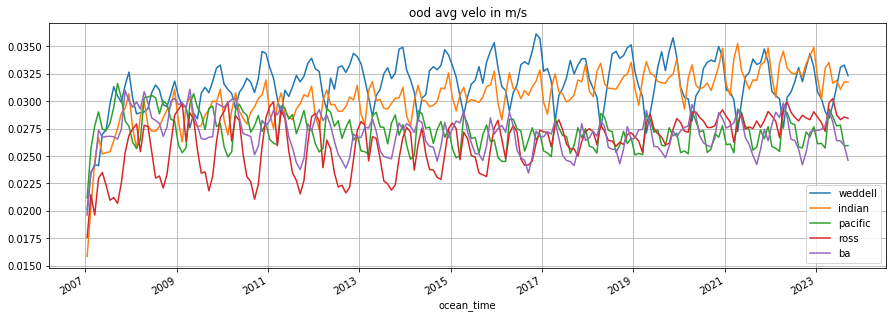

In [9]:
file_path = os.path.join(os.environ.get('rawdir'),'hre10_nudg','ocean_avg_00??.nc')
grd_path = os.path.join(os.environ.get('rawdir'),'gdata','hr_exp','waom10_stable_grd.nc')


print('Load files: ',file_path)
avgn = xr.open_mfdataset(file_path,chunks={'xi_rho':200,'eta_rho':200})
grd = xr.open_dataset(grd_path)


avgn = timeseries_3d_sectors(avgn,grd)